In [ ]:
# matplotlib.rcParams.update
#"python.dataScience.themeMatplotlibPlots": false

In [ ]:
# Open exploration with model noDICE_v4

In [2]:

import time
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators

from dicemodel.noDICE_v5 import PyDICE
model_version = 'v5'

import os
from dest_directories import gz_path, fig_path



In [3]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
# from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [4]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                            #  IntegerParameter('t2xco2_dist',0,2),
                            #  IntegerParameter('fdamage', 0, 2),
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             IntegerParameter('VD_switch', 0, 1)
                            ]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('prtp_dam',  0.001, 0.015),
                      RealParameter('emuc',  1.01, 2.00),
                      RealParameter('emdd', -1.0, 2.00),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]
    
    dice_sm.outcomes = [
                        TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR')
                        ]


In [6]:
n_scenarios = 5000
n_policies = 50


In [7]:
run = 2
start = time.time()
with MultiprocessingEvaluator(dice_sm, n_processes=8) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=n_policies)
end = time.time()

print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5000 scenarios * 50 policies * 1 model(s) = 250000 experiments
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] 75000 cases completed
[MainProcess/INFO] 100000 cases completed
[MainProcess/INFO] 125000 cases completed
[MainProcess/INFO] 150000 cases completed
[MainProcess/INFO] 175000 cases completed
[MainProcess/INFO] 200000 cases completed
[MainProcess/INFO] 225000 cases completed
[MainProcess/INFO] 250000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Experiment time is 5 mintues


In [8]:
results = experiments, outcomes
save_results(results, os.path.join(gz_path, str(run) + '_OE_' + str(n_scenarios) + 's_' + str(n_policies) + 'p_' + '.tar.gz'))

KeyboardInterrupt: 

In [ ]:
results = load_results(os.path.join(gz_path,'v4_fdamage_1a_OE_sr500s_20p_.tar.gz'))

In [15]:
# experiments, outcomes = results
raw_outcomes = outcomes
raw_experiments = experiments

In [13]:
# experiment debug (number of unique values for each variable)
experiments.info()
unique_counts = pd.DataFrame.from_records([(col, experiments[col].nunique()) for col in experiments.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts
# experiments['policy']



<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 0 to 249999
Data columns (total 17 columns):
VD_switch         250000 non-null float64
cback             250000 non-null float64
fosslim           250000 non-null float64
pop_gr            250000 non-null float64
sigma_gr          250000 non-null float64
t2xco2_index      250000 non-null float64
tfp_gr            250000 non-null float64
emdd              250000 non-null float64
emuc              250000 non-null float64
miu_period        250000 non-null float64
periodfullpart    250000 non-null float64
prtp_con          250000 non-null float64
prtp_dam          250000 non-null float64
sr                250000 non-null float64
scenario          250000 non-null object
policy            250000 non-null object
model             250000 non-null object
dtypes: float64(14), object(3)
memory usage: 44.3+ MB


,Column_Name,Num_Unique
16,model,1
0,VD_switch,2
9,miu_period,39
10,periodfullpart,41
7,emdd,50
15,policy,50
11,prtp_con,50
12,prtp_dam,50
13,sr,50
8,emuc,50


# Prepare outcomes as needed

In [17]:
#  dropping first two steps warm-up period and last 5 steps cooldown period cooldown periods
# outcomes[key].shape from (20000, 65) to (20000,58)
cleaned_outcome = {}
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape


(250000, 58)

In [18]:
# Values for 2300
end_outcome = {}
for key, value in outcomes.items():
    end_outcome[key] = value[:, -1]  
# end_outcome['Welfare']
# np.mean(cleaned_outcome['Damage Growth'], axis =0)


In [19]:
# remove outcomes that you dont need for pairs plots and time series
rem_list = [
    # 'Atmospheric Temperature',
    # 'Total Output',
    # 'Per Capita Consumption',
    'Consumption Growth',
    # 'Utility of Consumption',
    # 'Per Capita Damage',
    'Damage Growth',
    # 'Disutility of Damage',
    # 'Welfare',
    # 'Undiscounted Period Welfare',
    'Consumption SDR',
    'Damage SDR'
]
for key in rem_list:
    end_outcome.pop(key)

# Pairs plotting grouped by policy

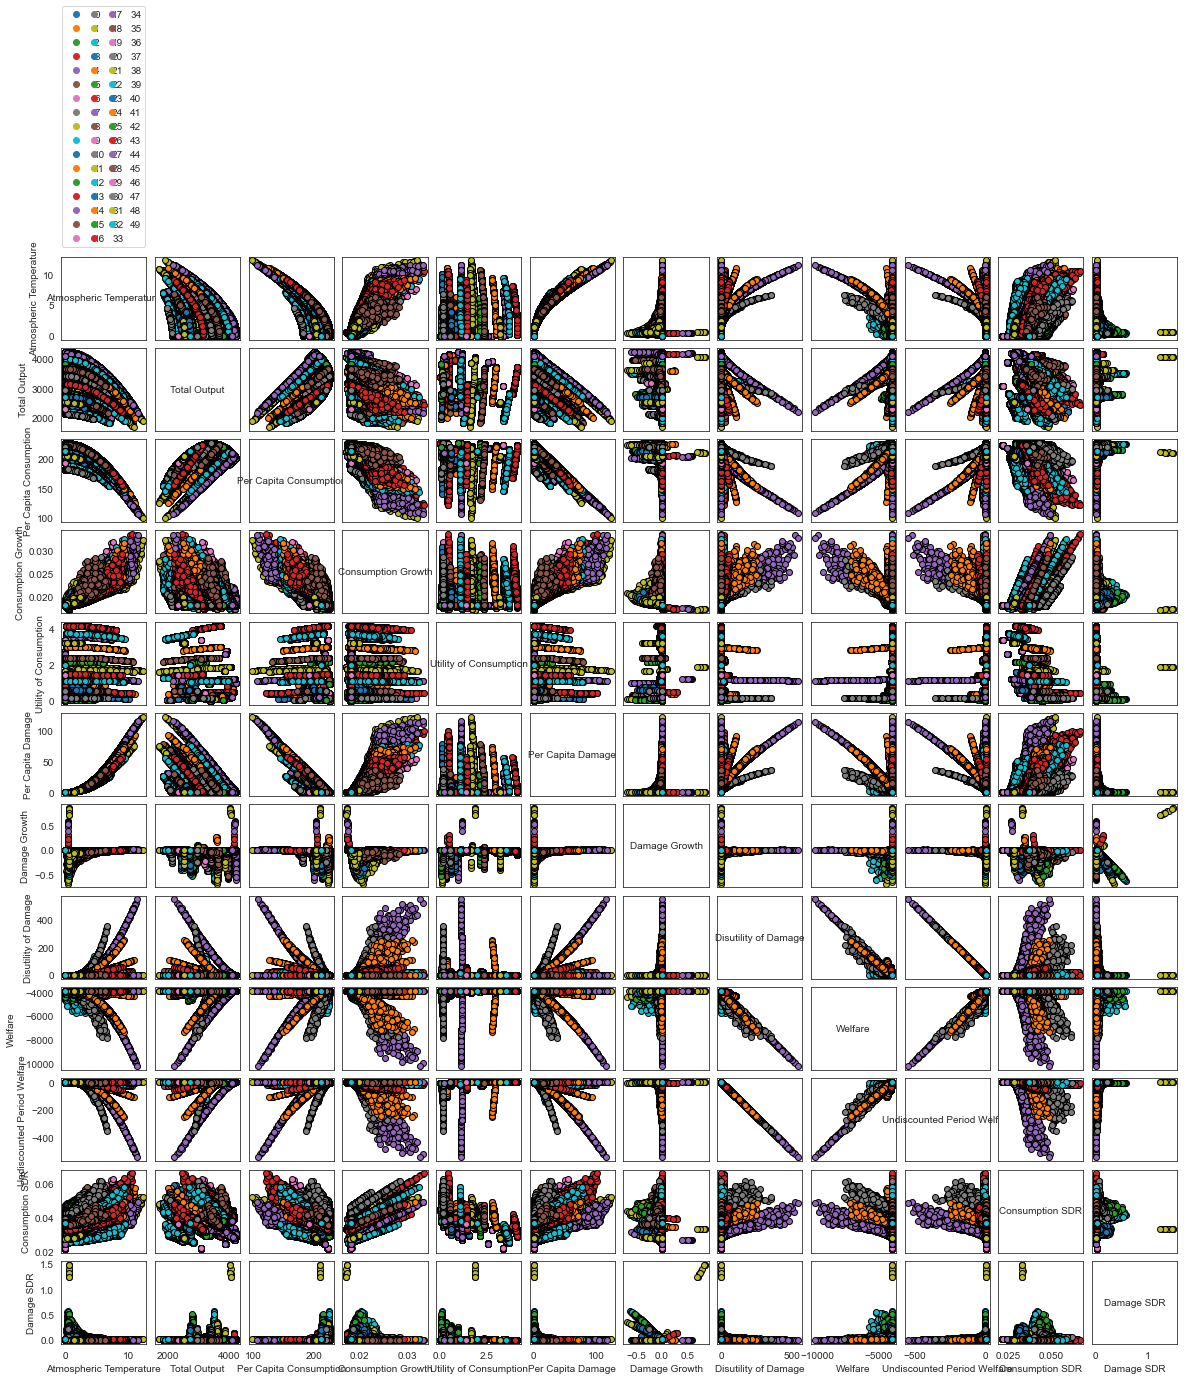

In [20]:

from ema_workbench.analysis import pairs_plotting
fig, axes = ema_workbench.analysis.pairs_plotting.pairs_scatter(experiments, outcomes,group_by='policy')
fig.set_size_inches(20,20)

repeat_token = 1
fig.savefig(os.path.join(fig_path, str(run) + '_OE_pairs_policy_' + str(repeat_token) + '.png'))

plt.show()

# Pairs plotting using ema workbench grouped by V(D) switch on/ off

In [22]:
grouping_specifiers = {'without V(D)':0, 'with V(D)':1}
grouping_labels = sorted(grouping_specifiers.keys())
grouping_specifiers_VD = [grouping_specifiers[key] for key in
                                       grouping_labels]


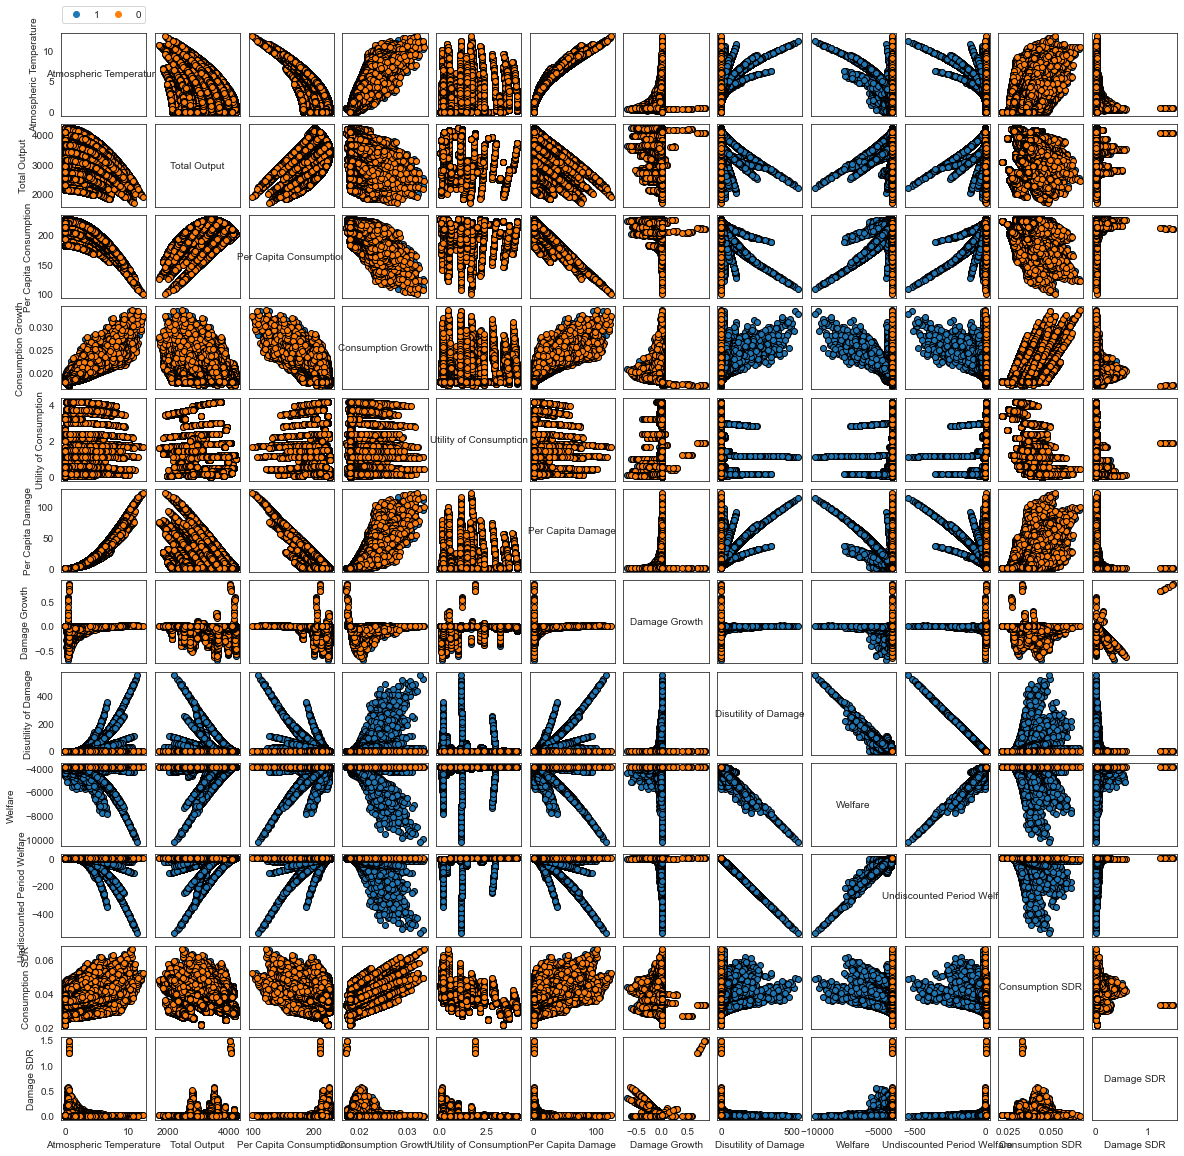

In [23]:
fig, axes = pairs_plotting.pairs_scatter(experiments,outcomes, group_by='VD_switch',grouping_specifiers=grouping_specifiers_VD, legend=True, transparent=True)
fig.set_size_inches(20,20)
plt.show()


In [24]:
fig.savefig(os.path.join(fig_path, str(run) + 'OE_pairsplot_by_VDswitch_ema' + str(n_scenarios) + 's' + str(n_policies) + 'p_' +  '.png'))


# Pairs plotting using ema workbench grouped by emdd range intervals 
(this isn't really working out)

In [ ]:
# %% 

grouping_specifiers = {'a':1, 'b':2, 'c':3}
grouping_labels = sorted(grouping_specifiers.keys())
grouping_specifiers = [grouping_specifiers[key] for key in
                                       grouping_labels]
# grouping_specifiers
low = np.min(experiments['emdd'])
high = np.max(experiments['emdd'])
grouping_specifiers_emdd = {'Low':
 low, 'mid

': 0, 'High'
: high}

In [26]:
grouping_specifiers_emdd = {'-0.99 to -0.5': -0.5, '-0.5 to 0': -0, '0 to 0.5': 0.5,'0.5 to 1': 1, '1 to 2': 2}
grouping_labels = sorted(grouping_specifiers.keys())
grouping_specifiers = [grouping_specifiers[key] for key in
                                       grouping_labels]


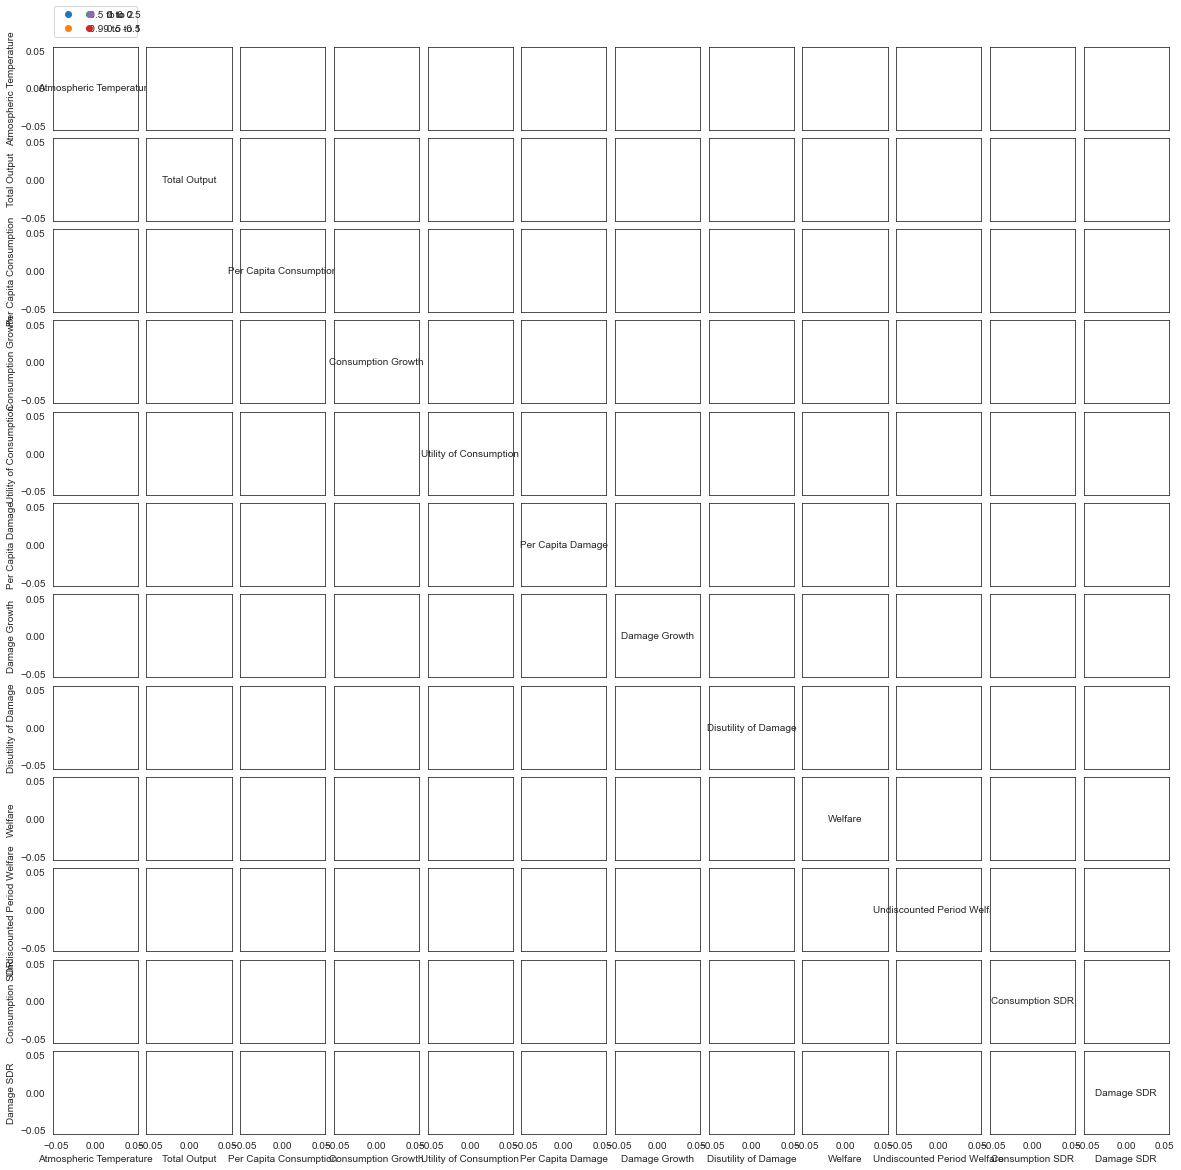

In [27]:
from ema_workbench.analysis import pairs_plotting, plotting_util
fig, axes = pairs_plotting.pairs_scatter(experiments,outcomes, group_by='emdd',grouping_specifiers=grouping_specifiers_emdd, 
legend=True, 
)
fig.set_size_inches(20,20)
plt.show()

# Pairs plotting by EMDD range through sns

In [ ]:
# # RealParameter('emdd', -1.0, 0.99)
# out_DF['emdd'] = out_DF['emdd'].apply(lambda x: 'Sub Zero' if x < 0 else 'Over Zero')

In [ ]:
clr_palette = ([sns.cubehelix_palette(8)[6],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[10]])

In [28]:
out_DF = pd.DataFrame(end_outcome)
out_DF.head()
emdd = experiments['emdd']
out_DF['emdd'] = emdd

In [29]:
out_DF['emdd'] = out_DF['emdd'].apply(
    lambda x: '-0.99 to -0.5' if x < -0.5
        else('-0.5 to 0' if (x < 0)
            else('0 to 0.5' if (x < 0.5)
                else ('0.5 to 0.99' if (x < 0.99) 
                    else('0.99 to 1.45' if (x < 1.45)
                        else '1.45 to 2'
                        )
                    )
                )
            )
    )

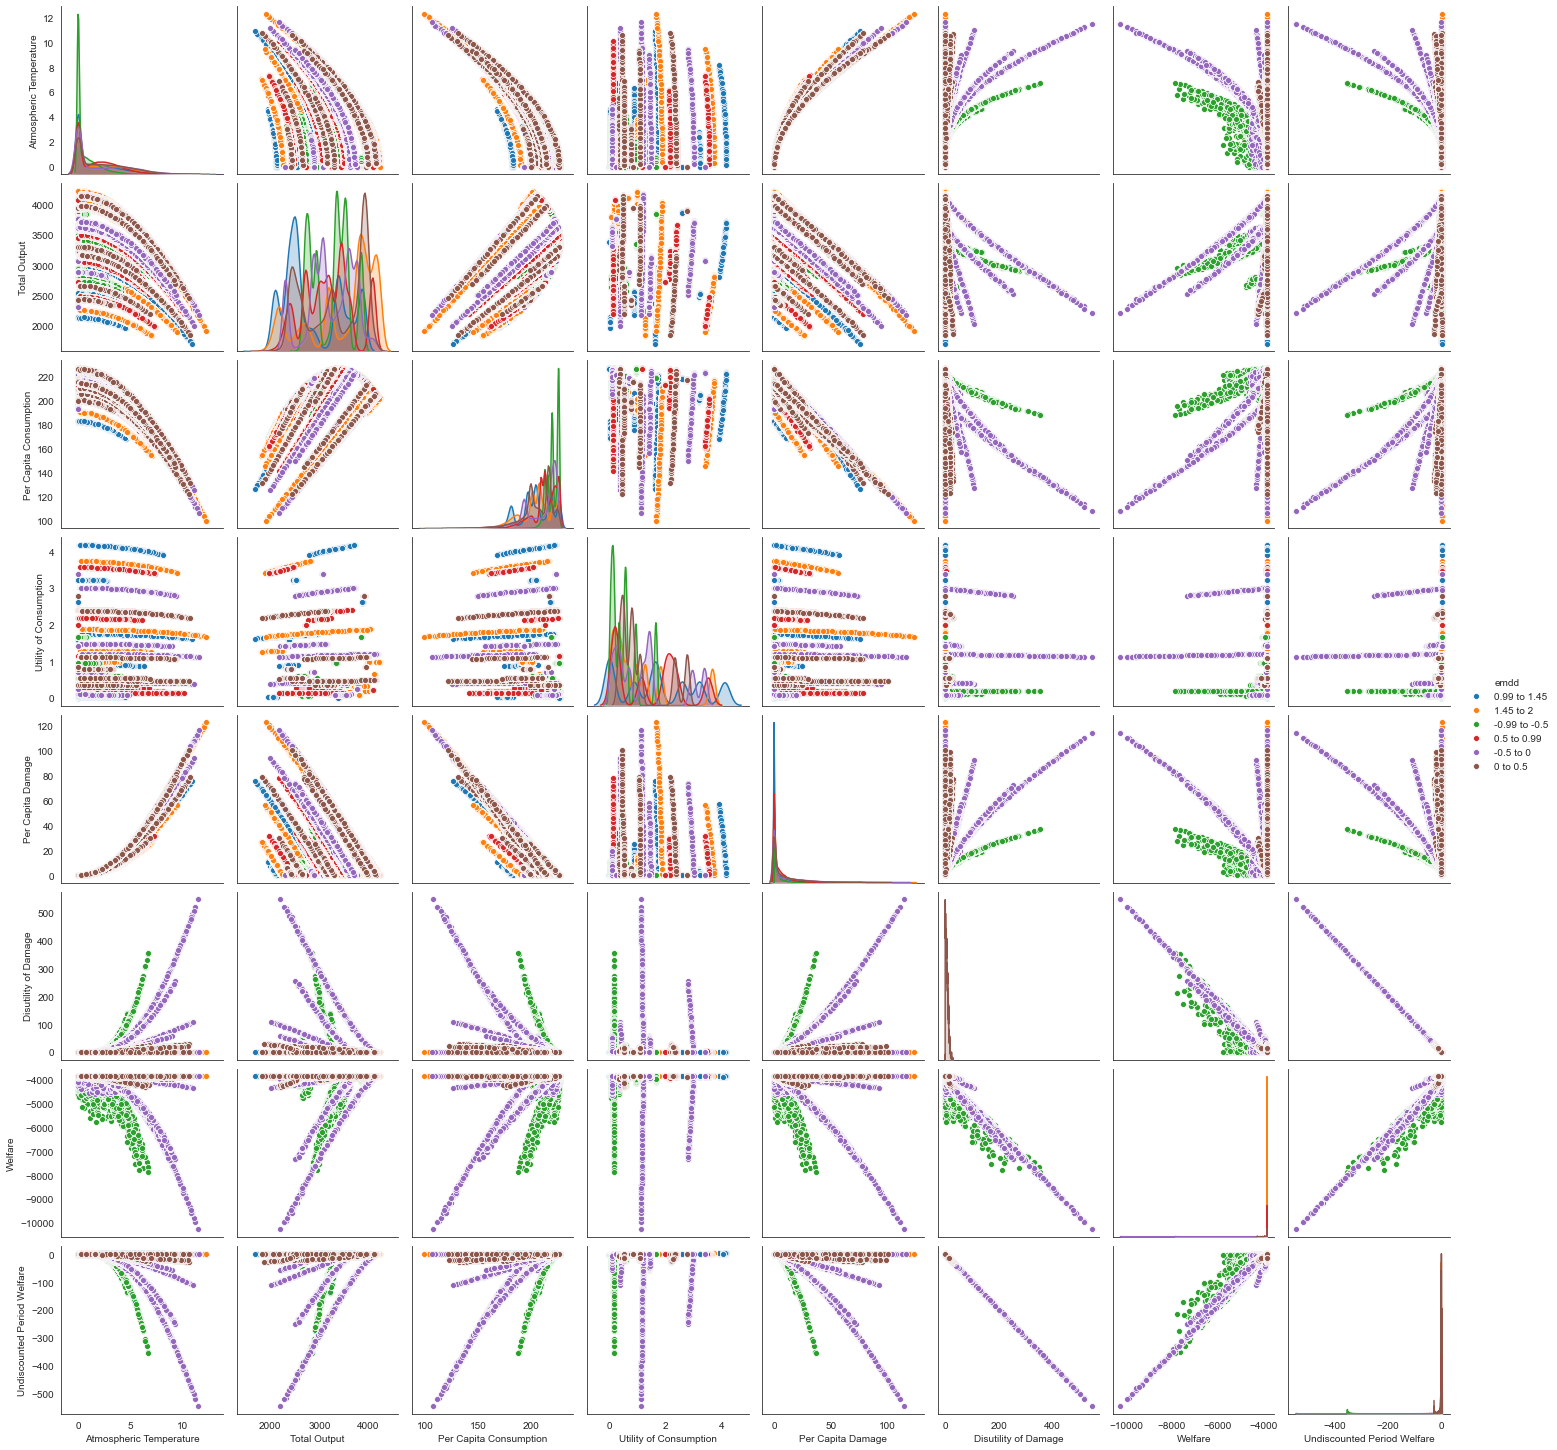

In [31]:
sns_plot = sns.pairplot(out_DF, hue='emdd', vars=list(end_outcome.keys())) # palette=clr_palette
fig.set_size_inches(20, 20)

sns_plot.savefig(os.path.join(fig_path, str(run) + '_v5_snspairplot_by_emdd_2330' +'.png'))
plt.show()

In [ ]:
sns.set_style("whitegrid")

sns_plot = sns.pairplot(out_DF, hue='emdd', palette=clr_palette, vars=list(end_outcome.keys()))
# fig.set_size_inches(12, 5)

repeat_token = 1
sns_plot.savefig(os.path.join(fig_path,'1a_pairs_2330_' + str(repeat_token)+'_.png'))
plt.show()

# Time Series Plotting

In [34]:
# Add a 'TIME' outcome 
TimeLine = []
for i in range(65):
    TimeLine.append(2010+i*5)
# TimeLine
cleaned_outcome["TIME"] = np.array([TimeLine])
# outcomes

In [ ]:
# sns.set_style("whitegrid")

for outcome in outcomes.keys():
    fig,axes=plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, legend=True)
    
    fig.set_size_inches(25,10)
    fig.savefig(os.path.join(fig_path, str(run) + '_v5_OE_TimeSeries_' + str(outcome) + '.png'))
plt.show()



In [ ]:
# Time series outcome grouped by V(D) switch

for outcome in outcomes.keys():
    fig,axes=plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='VD_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

    fig.set_size_inches(25, 10)
    
    repeat_token = 1
    fig.savefig(os.path.join(fig_path,'1a_Time_grouped_' + str(outcome) + '_repeat' +str(repeat_token) + '.png'))
plt.show()


In [ ]:
# Time Series of outcomes grouped by policy

for outcome in outcomes.keys():
    fig,axes=plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='policy', legend=True)
    # fig.tight_layout()
    fig.set_size_inches(15,10)
    fig.savefig(os.path.join(fig_path,'Grouped_Time_' + str(outcome) + '.png'))
plt.show()

In [ ]:
out_DF = pd.DataFrame(outcomes)
out_DF.to_csv('v5_output.csv')